In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [31]:
with open("../data/labeled_data_2.json", "r") as json_file:
    data = json.load(json_file)

y = np.array([entry['score'] for entry in data.values()])
X = np.array([np.array(list({k : v for k, v in entry.items() if k != 'score'}.values())) for entry in data.values()])

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_eval, y_eval = torch.tensor(X_eval, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32)

# Neural Network Regression with 1 Hidden Layer

In [34]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
def train_RegressionNN(hidden_size=32, num_epochs=1000, print_progress=False, l2_reg=0.01):
    input_size = X.shape[1]  
    output_size = 1

    model = RegressionNN(input_size, hidden_size, output_size)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=l2_reg)
    
    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(torch.squeeze(outputs), torch.squeeze(y_train))

        l2_term = 0
        for param in model.parameters():
            l2_term += torch.norm(param, p=2)

        loss = loss + l2_reg * l2_term

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_progress and (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

In [38]:
def eval_RegressionNN(model, eval_input, eval_label):
    model.eval()
    with torch.no_grad():
        predicted_output = model(eval_input)

        predicted_output = predicted_output.numpy()
        labels = eval_label.numpy()

        r2 = r2_score(labels, predicted_output)

        return r2
    
model = train_RegressionNN(hidden_size=256)

r2 = eval_RegressionNN(model, X_train, y_train)
print("R^2 Score (on the training data):", r2)

r2 = eval_RegressionNN(model, X_eval, y_eval)
print("R^2 Score (on the evaluation data):", r2)

R^2 Score (on the training data): 0.9705124578723068
R^2 Score (on the evaluation data): -0.8466979676247521


The following code cell takes a bit of time to run (approximately 3 minutes). Note that this approach does not seem promising all despite the high $R^2$ score for the training data. This is explained below.

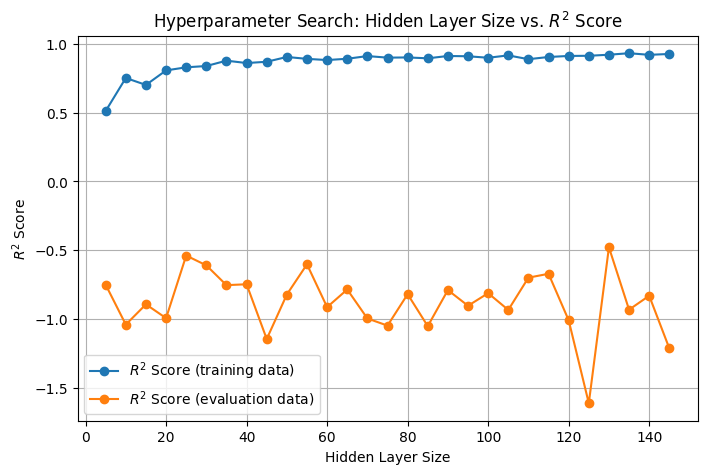

In [37]:
hidden_layer_sizes = list(range(5, 150, 5))

r2_scores_train, r2_scores_eval = [], []

for hidden_size in hidden_layer_sizes:
    r2_trains, r2_evals = [], []
    for _ in range(10):
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)
        X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
        X_eval, y_eval = torch.tensor(X_eval, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32)
        model = train_RegressionNN(hidden_size=hidden_size, num_epochs=1000)

        r2_train = eval_RegressionNN(model, X_train, y_train)
        r2_trains.append(r2_train)

        r2_eval = eval_RegressionNN(model, X_eval, y_eval)
        r2_evals.append(r2_eval)
        
    r2_scores_train.append(sum(r2_trains) / len(r2_trains))
    r2_scores_eval.append(sum(r2_evals) / len(r2_evals))

plt.figure(figsize=(8, 5))
plt.plot(hidden_layer_sizes, r2_scores_train, marker='o', linestyle='-', label="$R^2$ Score (training data)")
plt.plot(hidden_layer_sizes, r2_scores_eval, marker='o', linestyle='-', label="$R^2$ Score (evaluation data)")
plt.title('Hyperparameter Search: Hidden Layer Size vs. $R^2$ Score')
plt.xlabel('Hidden Layer Size')
plt.ylabel('$R^2$ Score')
plt.grid(True)
plt.legend()
plt.show()

Note that the $R^2$ score for training data looks great while the $R^2$ score for evaluation data looks abysmal. 


This is because the neural network has overfit to the data. That is, the neural network has learned to fit almost exactly to the dataset instead of learning the general patterns. This is likely just a problem of not having enough data to train on. I see no way to use neural networks effectively here.